# **Spatial Patterns of insect Diversity in continetal Ecuador**

## **Completeness analysis**

Author: Daning Montaño - Ocampo

# **1. Packages and libraries**

In [3]:
library(dplyr)
library(ggplot2)
library(sf)
library(iNEXT)
library(tidyr)
library(vegan)
library(tibble)
#library(doParallel)
#

# 2. Load clean data and grids

In [4]:
insects_records = read.csv("Data/Records/insects_records_clean.csv")%>%
  filter(taxonRank == c("species"))

# Transform to sf object
insects_records_sf = st_as_sf(insects_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)


In [5]:
grid_10km = st_read("Data/shp/grid_10km.shp")
grid_10km$id_10km = grid_10km$id


Reading layer `grid_10km' from data source `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\grid_10km.shp' using driver `ESRI Shapefile'
Simple feature collection with 7268 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -81.32114 ymin: -6.003704 xmax: -74.19902 ymax: 2.31959
Geodetic CRS:  WGS 84


# 3. Join points to grids

By locating the points, we will extract ID information from the grid tables. This allows us to work on the analyses and simply join the results to the grid, making the process more efficient.

In [6]:
recors_grid_10km <- st_join(
  insects_records_sf,
  grid_10km %>% select(id),   
  join = st_within                              # inside polygons
)

head(recors_grid_10km)

Simple feature collection with 6 features and 18 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -79.73478 ymin: -1.437528 xmax: -78.87119 ymax: 0.532611
Geodetic CRS:  WGS 84
  id_record database_name database_id                         occurrenceID     basisOfRecord verbatimEventDate identifiedBy                                    recordedBy year
1         1          BNDB  BNDB_10610 86e65c58-00ef-40b4-8484-16aec38ecc9c PreservedSpecimen        2015-07-04 Bonifacii R.                                  Bonifacii R. 2015
2         2          BNDB  BNDB_10611 d7acf7c1-ac14-410f-a636-bb6568b11e49 PreservedSpecimen        1987-08-06  Dressler R. Dressler R.; Hills H. Whittem W & Williams N. 1987
3         3          BNDB  BNDB_10612 648cd51d-1aeb-4f37-a9aa-ea6ba9daf58b PreservedSpecimen        2015-10-30 Bonifacii R.                                  Bonifacii R. 2015
4         4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb PreservedSpecimen        2015-

# 4. Records per 10 km grid

We calculate the number of records per 10 km grid usind id_10km

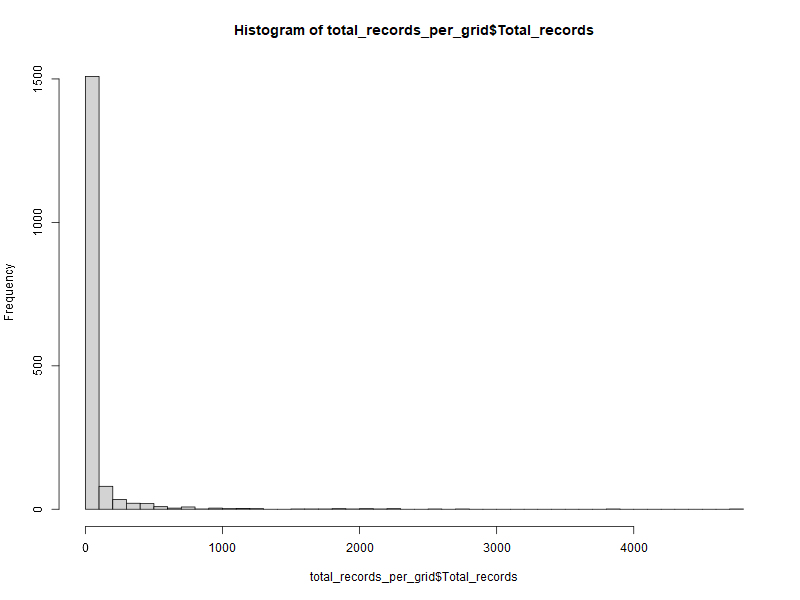

In [7]:
total_records_per_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id)%>%
  summarise(Total_records = n()) %>%
  as.data.frame()
hist(total_records_per_grid$Total_records, breaks = 50)

Join results to 10 km grid

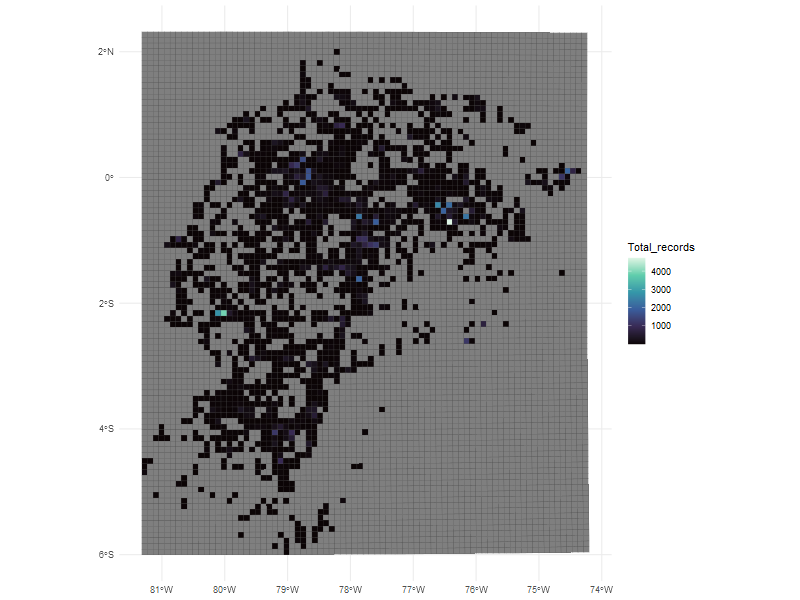

In [8]:
grid_10km = grid_10km%>% 
  left_join(total_records_per_grid, by = "id")

ggplot(grid_10km) +
  geom_sf(aes(fill = Total_records), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

# 5. Sp per 10 km grid

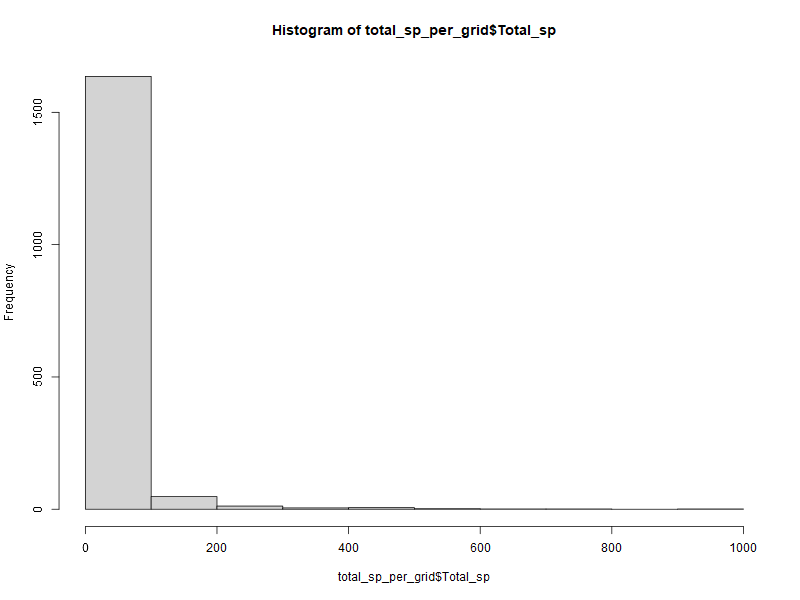

In [9]:
total_sp_per_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id)%>%
  distinct(scientificName) %>%
  summarise(Total_sp = n()) %>%
  as.data.frame()
hist(total_sp_per_grid$Total_sp)

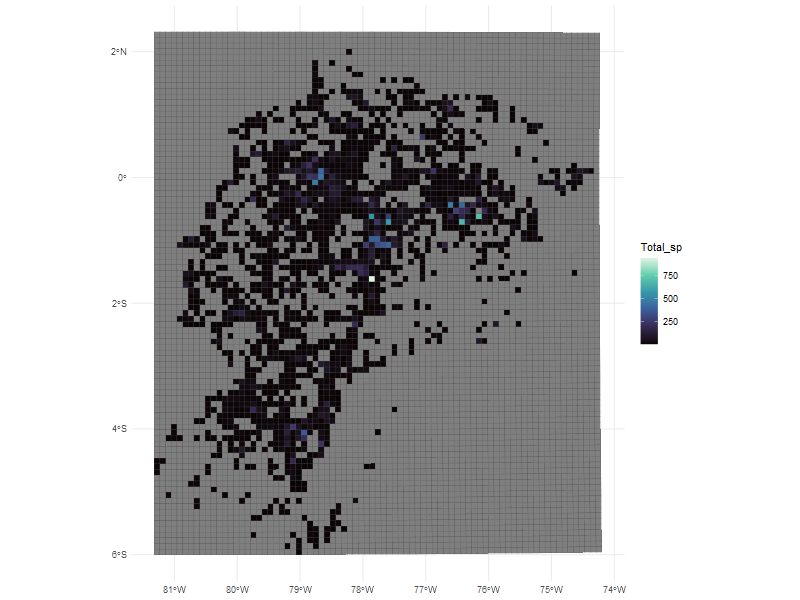

In [10]:
grid_10km = grid_10km%>% 
  left_join(total_sp_per_grid, by = "id")
ggplot(grid_10km) +
  geom_sf(aes(fill = Total_sp), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

## 5.1 Correlaction records x sp

In [11]:
cor(grid_10km$Total_records, grid_10km$Total_sp, method = "spearman", use = "complete.obs")

[1] 0.947287

Warning messages:
1: Removed 5556 rows containing non-finite outside the scale range (`stat_smooth()`). 
2: Removed 5556 rows containing missing values or values outside the scale range (`geom_point()`). 


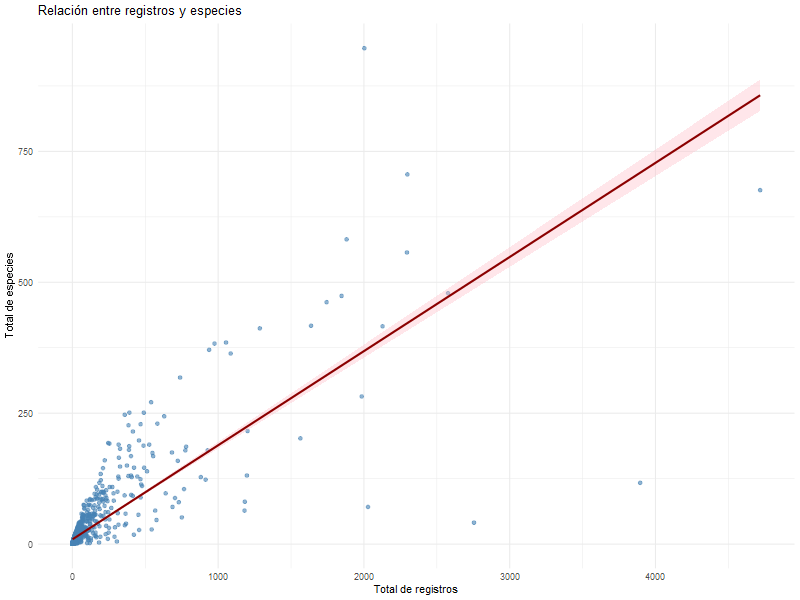

`geom_smooth()` using formula = 'y ~ x'

In [12]:
ggplot(grid_10km, aes(x = Total_records, y = Total_sp)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", fill = "pink") +
  theme_minimal() +
  labs(
    x = "Total de registros",
    y = "Total de especies",
    title = "Relación entre registros y especies"
  )

# 6. Sampling Completness

## 6.1. Completness - Country level

Calculate completnes for all country using incidens data and each 10 km cell is a unit

In [13]:
ecu_incidens_matrix <- recors_grid_10km %>%
  as.data.frame() %>%
  distinct(id, scientificName) %>%          # 1 por unidad-especie
  mutate(val = 1L) %>%
  pivot_wider(names_from = scientificName, values_from = val, values_fill = 0) %>%
  arrange(id)
ids_unidades_ecu <- ecu_incidens_matrix$id

# Quitamos la columna de IDs para dejar solo 0/1 por especie
incidences_ecu_df <- ecu_incidens_matrix %>% dplyr::select(-id)

# Matriz of incidences - iNext
inext_in_ecu <- list(ensamblaje = as.data.frame(t(incidences_ecu_df)))




Use iNEXT funtion to calculate the sampling coverage in Ecuador, an only extract richness (q=0) and sampling coverage

In [14]:
result_inext_ecu <- iNEXT(inext_in_ecu, q = 0, datatype = "incidence_raw", se = TRUE, conf = 0.95,nboot= 100 )
result_inext_ecu

Compare 1 assemblages with Hill number order q = 0.
$class: iNEXT

$DataInfo: basic data information
  Assemblage    T     U S.obs     SC   Q1   Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9 Q10
1 ensamblaje 1712 36565  9240 0.8735 4627 1564 769 467 325 245 183 136 107  99

$iNextEst: diversity estimates with rarefied and extrapolated samples.
$size_based (LCL and UCL are obtained for fixed size.)

   Assemblage    t        Method Order.q          qD     qD.LCL      qD.UCL         SC     SC.LCL     SC.UCL
1  ensamblaje    1   Rarefaction       0    21.35806    21.1321    21.58403 0.01288256 0.01236845 0.01339667
10 ensamblaje  856   Rarefaction       0  6394.49819  6327.5728  6461.42355 0.80363164 0.80083792 0.80642535
20 ensamblaje 1712      Observed       0  9240.00000  9131.7514  9348.24856 0.87350820 0.87076119 0.87625521
30 ensamblaje 2523 Extrapolation       0 11115.07641 10968.2259 11261.92690 0.90818211 0.90509457 0.91126966
40 ensamblaje 3424 Extrapolation       0 12602.04537 12408.9258 1279

In [15]:
info_inext_ecu <- DataInfo(inext_in_ecu, datatype = "incidence_raw")  # columna SC = sample coverage; T = # unidades de muestreo
info_inext_ecu


Warning messages:
1: In ggiNEXT.iNEXT(result_inext_ecu, type = 2) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q
2: `aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the iNEXT package.
  Please report the issue at <]8;;https://github.com/JohnsonHsieh/iNEXT/issueshttps://github.com/JohnsonHsieh/iNEXT/issues]8;;>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 


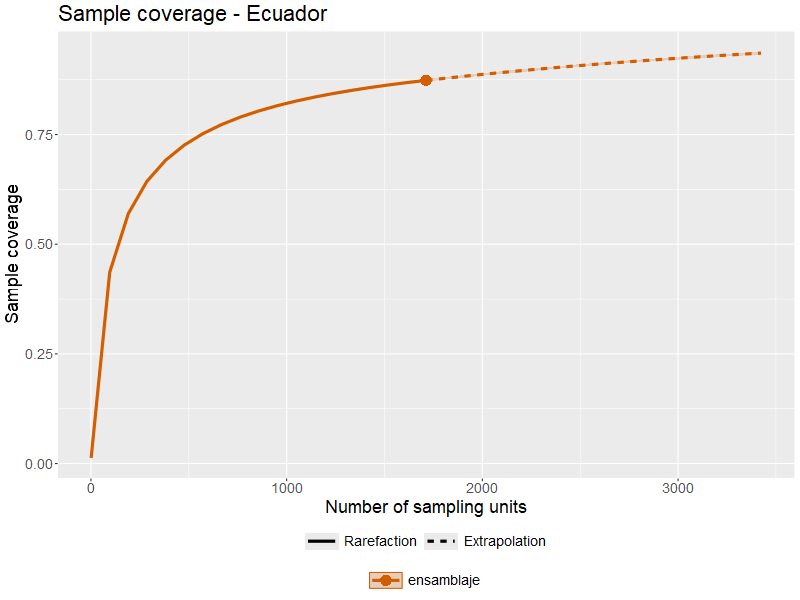

In [16]:
plot_units_sc <- ggiNEXT(result_inext_ecu, type = 2) + labs(title = "Sample coverage - Ecuador")
plot_units_sc

Warning message:
In ggiNEXT.iNEXT(result_inext_ecu, type = 1) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


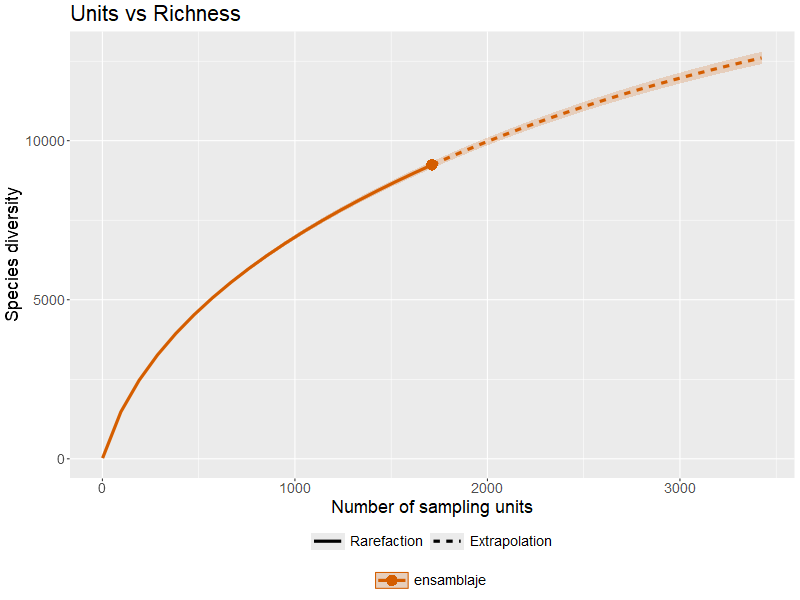

In [17]:
plot_units_richness <- ggiNEXT(result_inext_ecu, type = 1) + labs(title = "Units vs Richness")
plot_units_richness

## 6.2. Grid

### 6.2.1 Sample coverage

In [18]:
recors_grid_10km

Simple feature collection with 117233 features and 18 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.3037 ymin: -5.911483 xmax: -74.40273 ymax: 2.00376
Geodetic CRS:  WGS 84
First 10 features:
   id_record database_name database_id                         occurrenceID     basisOfRecord verbatimEventDate identifiedBy                                    recordedBy year
1          1          BNDB  BNDB_10610 86e65c58-00ef-40b4-8484-16aec38ecc9c PreservedSpecimen        2015-07-04 Bonifacii R.                                  Bonifacii R. 2015
2          2          BNDB  BNDB_10611 d7acf7c1-ac14-410f-a636-bb6568b11e49 PreservedSpecimen        1987-08-06  Dressler R. Dressler R.; Hills H. Whittem W & Williams N. 1987
3          3          BNDB  BNDB_10612 648cd51d-1aeb-4f37-a9aa-ea6ba9daf58b PreservedSpecimen        2015-10-30 Bonifacii R.                                  Bonifacii R. 2015
4          4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb Pre

In [19]:
# Unique 10-km IDs
cid_10km <- unique(recors_grid_10km$id)

# Results container (abundance-based)
results_s_cov <- data.frame(
  id_10km = integer(),
  Samplig_coverage = numeric(),  # SC observado (abundancia)
  n_records = numeric(),         # n total de registros
  sp_obs = numeric(),         # S.obs
  f1 = numeric(),                # singletons
  f2 = numeric(),                # doubletons
  sc_ext = numeric(),            # SC al extremo de la curva
  n_records_ext = numeric(),     # n (size) al extremo
  sp_ext = numeric(),         # qD al extremo
  stringsAsFactors = FALSE
)

# Progress bar
pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
count <- 0

for (i in cid_10km) {

  # 1) Filtrar todo dentro del 10-km (SIN usar id_2km)
  records_by_id <- recors_grid_10km %>%
    dplyr::filter(id == i)

  # 2) Vector de abundancias por género (n° de registros por género)
  #    - quitar NAs en genus
  #    - quedarnos con géneros con n > 0
  abund_tbl <- records_by_id %>%
    dplyr::filter(!is.na(scientificName)) %>%
    dplyr::count(scientificName, name = "n")

  abund_vec <- abund_tbl$n
  names(abund_vec) <- abund_tbl$scientificName
  abund_vec <- abund_vec[abund_vec > 0]

  # 3) Casos sin información suficiente
  if (length(abund_vec) == 0L) {
    sampl_result <- data.frame(
      Samplig_coverage = NA_real_,
      n_records = NA_real_,
      sp_obs = NA_real_,
      f1 = NA_real_,
      f2 = NA_real_,
      sc_ext = NA_real_,
      n_records_ext = NA_real_,
      sp_ext = NA_real_,
      stringsAsFactors = FALSE
    )
  } else {
    # 4) iNEXT con abundancias (curva en función de # de registros)
    sampl_result <- tryCatch({
      res_abund <- iNEXT(
        list(ensamblaje = abund_vec),
        q = 0,
        datatype = "abundance",
        se = FALSE
      )

      # DataInfo (abundance)
      sc_obs <- res_abund$DataInfo$SC
      n_obs  <- res_abund$DataInfo$n
      s_obs  <- res_abund$DataInfo$S.obs
      f1     <- res_abund$DataInfo$f1
      f2     <- res_abund$DataInfo$f2

      # coverage_based: SC y qD al extremo (última fila)
      cb <- res_abund$iNextEst$coverage_based
      sc_ext <- if (!is.null(cb) && nrow(cb) > 0) tail(cb$SC, 1) else NA_real_
      qd_ext <- if (!is.null(cb) && nrow(cb) > 0) tail(cb$qD, 1) else NA_real_

      # size_based: n (m) al extremo (última fila)
      sb <- res_abund$iNextEst$size_based
      n_ext <- if (!is.null(sb) && nrow(sb) > 0) tail(sb$m, 1) else NA_real_

      data.frame(
        Samplig_coverage = sc_obs,
        n_records = n_obs,
        sp_obs = s_obs,
        f1 = f1,
        f2 = f2,
        sc_ext = sc_ext,
        n_records_ext = n_ext,
        sp_ext = round(qd_ext, 0),
        stringsAsFactors = FALSE
      )
    }, error = function(e) {
      data.frame(
        Samplig_coverage = NA_real_,
        n_records = NA_real_,
        sp_obs = NA_real_,
        f1 = NA_real_,
        f2 = NA_real_,
        sc_ext = NA_real_,
        n_records_ext = NA_real_,
        sp_ext = NA_real_,
        stringsAsFactors = FALSE
      )
    })
  }

  # 5) Append por celda 10-km
  results_s_cov <- rbind(
    results_s_cov,
    cbind(data.frame(id_10km = i, stringsAsFactors = FALSE), sampl_result)
  )

  count <- count + 1
  setTxtProgressBar(pb, count)
}

# Close progress bar
close(pb)



  |========================================================================================================================================================================| 100%

There were 50 or more warnings (use warnings() to see the first 50)


In [20]:
results_s_cov

    id_10km Samplig_coverage n_records sp_obs  f1  f2    sc_ext n_records_ext sp_ext
1      2228           0.7678       146     58  34   7 0.8465068           292     86
2      1606           0.8022        13      7   3   3 0.9733362            26      8
3      2508           0.9060      1202    216 113  27 0.9417453          2404    306
4      2868           0.5332       113     75  53  14 0.7257095           226    116
5      4814           0.7526       234     88  58  12 0.8366488           468    135
6      4815           0.9442      2577    479 144 127 0.9904310          5154    547
7      4907           0.6112        43     26  17   6 0.8101151            86     38
8      4999           0.9206      2128    416 169 100 0.9756994          4256    515
9      3185           0.6923         9      5   3   1 0.8502876            18      7
10     2145           0.7455       184     79  47  16 0.8714970           368    113
11     3619           0.7620       121     53  29  12 0.8963760  

### 6.2.4  Join Sample covergate with 10 km grid

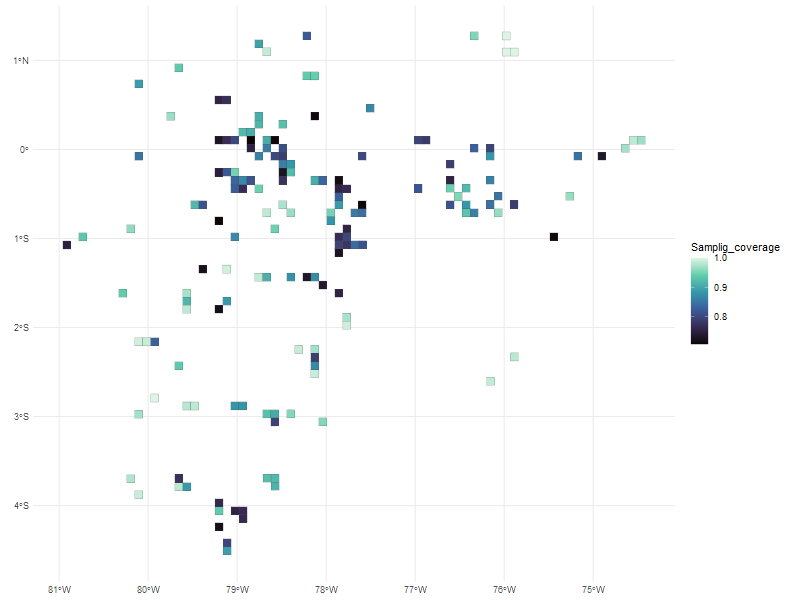

In [56]:
results_sampling_effor =  grid_10km%>%
  left_join(results_s_cov, by = "id_10km") 


results_sampling_effor_filter  = results_sampling_effor %>% filter(Total_records >= 100 )%>%
    filter(Samplig_coverage >= 0.7 )

ggplot(results_sampling_effor_filter) +
  geom_sf(aes(fill = Samplig_coverage ), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

In [57]:
results_sampling_effor_filter

Simple feature collection with 162 features and 16 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -4.553896 xmax: -74.41422 ymax: 1.322877
Geodetic CRS:  WGS 84
First 10 features:
     id     left      top    right   bottom id_10km Total_records Total_sp Samplig_coverage n_records sp_obs f1 f2    sc_ext n_records_ext sp_ext                       geometry
1   406 504459.9  9886386 514459.9  9876386     406           142       53           0.7474       142     53 36  9 0.8471813           284     81 POLYGON ((-80.95991 -1.0279...
2   589 524459.9  9896386 534459.9  9886386     589           766      105           0.9322       766    105 52 15 0.9619233          1532    144 POLYGON ((-80.78016 -0.9374...
3  1056 574459.9  9826386 584459.9  9816386    1056           231       35           0.9397       231     35 14  8 0.9808087           462     43 POLYGON ((-80.33061 -1.5706...
4  1140 584459.9  9906386 594459.9  9896386    1140           126       11

# 7. Exportar resultados

In [58]:

 st_write(results_sampling_effor, "Results/shp/grid_10km_sampling.shp", append=FALSE)
 st_write(results_sampling_effor_filter, "Results/shp/grid_10km_sampling_filter.shp", append=FALSE)

Deleting layer `grid_10km_sampling' using driver `ESRI Shapefile'
Writing layer `grid_10km_sampling' to data source `Results/shp/grid_10km_sampling.shp' using driver `ESRI Shapefile'
Writing 7268 features with 16 fields and geometry type Polygon.


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver


Deleting layer `grid_10km_sampling_filter' using driver `ESRI Shapefile'
Writing layer `grid_10km_sampling_filter' to data source `Results/shp/grid_10km_sampling_filter.shp' using driver `ESRI Shapefile'
Writing 162 features with 16 fields and geometry type Polygon.


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver
